# DeepFake Detection - DFDC Dataset Implementation

In [1]:
import cv2
import os
import json
import numpy as np
import urllib.request

# --- Configuration for Kaggle Paths ---
TRAIN_FRAME_FOLDER = '/kaggle/input/deepfake-detection-challenge/train_sample_videos'
OUTPUT_DATA_DIR = 'dataset'
REAL_OUTPUT = os.path.join(OUTPUT_DATA_DIR, 'real')
FAKE_OUTPUT = os.path.join(OUTPUT_DATA_DIR, 'fake')

# --- Face Detector Configuration ---
MAX_FRAMES_PER_VIDEO = 15
IMG_SIZE = 128
XML_FILE_NAME = 'haarcascade_frontalface_default.xml'
CASCADE_PATH = XML_FILE_NAME # File will be downloaded to the working directory

# --- Function to Download the Cascade File ---
def download_cascade(filename):
    if os.path.exists(filename):
        print(f"✅ Cascade file '{filename}' already exists.")
        return True
    
    # Official OpenCV GitHub raw file URL
    url = f'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/{filename}'
    
    print(f"⬇️ Downloading required cascade file from GitHub...")
    try:
        urllib.request.urlretrieve(url, filename)
        if os.path.exists(filename):
            print(f"✅ Download successful. File saved as '{filename}'.")
            return True
        else:
            print("❌ Download failed: File was not created.")
            return False
    except Exception as e:
        print(f"❌ Failed to download cascade file: {e}")
        return False

# --- Execute Download ---
if not download_cascade(XML_FILE_NAME):
    print("FATAL ERROR: Could not secure the face detection cascade file. Cannot proceed.")
    exit()
    
# --- Create Output Directories ---
os.makedirs(REAL_OUTPUT, exist_ok=True)
os.makedirs(FAKE_OUTPUT, exist_ok=True)

# --- Load Face Detector ---
try:
    face_cascade = cv2.CascadeClassifier(CASCADE_PATH)
    if face_cascade.empty():
        raise SystemError("OpenCV failed to load the cascade file, even after download.")
except SystemError as e:
    print(f"\n--- FATAL ERROR: CASCADE FILE NOT LOADED ---\n")
    print(f"The file '{CASCADE_PATH}' was found but could not be loaded by OpenCV. Error: {e}")
    print("Execution halted.")
    exit()

# --- Load Metadata ---
try:
    with open(os.path.join(TRAIN_FRAME_FOLDER, 'metadata.json'), 'r') as file:
        data = json.load(file)
except FileNotFoundError:
    print(f"Error: metadata.json not found in {TRAIN_FRAME_FOLDER}. Check your Kaggle data source.")
    exit()

# --- Frame Extraction Logic ---
list_of_train_data = [f for f in os.listdir(TRAIN_FRAME_FOLDER) if f.endswith('.mp4')]
face_detected_count = 0
total_videos = len(list_of_train_data)
processed_videos = 0

print(f"Starting face extraction from {total_videos} videos...")

for vid in list_of_train_data:
    processed_videos += 1
    vid_path = os.path.join(TRAIN_FRAME_FOLDER, vid)
    cap = cv2.VideoCapture(vid_path)
    frameRate = cap.get(cv2.CAP_PROP_FPS)
    
    if vid not in data or data[vid]['label'] not in ['REAL', 'FAKE']:
        continue

    label = data[vid]['label']
    frame_count_for_video = 0
    frame_skip_interval = max(1, int(frameRate) // 2)
    frame_index = 0

    while cap.isOpened() and frame_count_for_video < MAX_FRAMES_PER_VIDEO:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_index % frame_skip_interval == 0:
            # Check if frame is valid before converting color
            if frame is None or frame.size == 0:
                frame_index += 1
                continue
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Detect faces
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            
            for (x, y, w, h) in faces:
                x1, y1, x2, y2 = x, y, x + w, y + h
                
                # Crop and ensure it's within bounds
                crop_img = frame[y1:y2, x1:x2]
                
                if crop_img.size > 0:
                    output_folder = REAL_OUTPUT if label == 'REAL' else FAKE_OUTPUT
                    filename = f"{vid.split('.')[0]}_{frame_count_for_video}.png"
                    
                    cv2.imwrite(os.path.join(output_folder, filename), cv2.resize(crop_img, (IMG_SIZE, IMG_SIZE)))
                    
                    frame_count_for_video += 1
                    face_detected_count += 1
                    
                    if frame_count_for_video >= MAX_FRAMES_PER_VIDEO:
                        break

        frame_index += 1
        
    cap.release()
    if processed_videos % 50 == 0:
        print(f"Processed {processed_videos}/{total_videos} videos. Total frames extracted so far: {face_detected_count}.")

print(f"\nCompleted preprocessing. Total faces saved: {face_detected_count} in '{OUTPUT_DATA_DIR}' directory.")

⬇️ Downloading required cascade file from GitHub...
✅ Download successful. File saved as 'haarcascade_frontalface_default.xml'.
Starting face extraction from 400 videos...
Processed 50/400 videos. Total frames extracted so far: 674.
Processed 100/400 videos. Total frames extracted so far: 1381.
Processed 150/400 videos. Total frames extracted so far: 2032.
Processed 200/400 videos. Total frames extracted so far: 2714.
Processed 250/400 videos. Total frames extracted so far: 3395.
Processed 300/400 videos. Total frames extracted so far: 4075.
Processed 350/400 videos. Total frames extracted so far: 4792.
Processed 400/400 videos. Total frames extracted so far: 5464.

Completed preprocessing. Total faces saved: 5464 in 'dataset' directory.


Loaded 348 sequences (videos) with 15 frames each.
Building FINAL Optimized model...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 15, 2048)          23587712  
_________________________________________________________________
dropout_34 (Dropout)         (None, 15, 2048)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 512)               5244928   
_________________________________________________________________
dense_34 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 258       
Total params: 28,898,562
Trainable

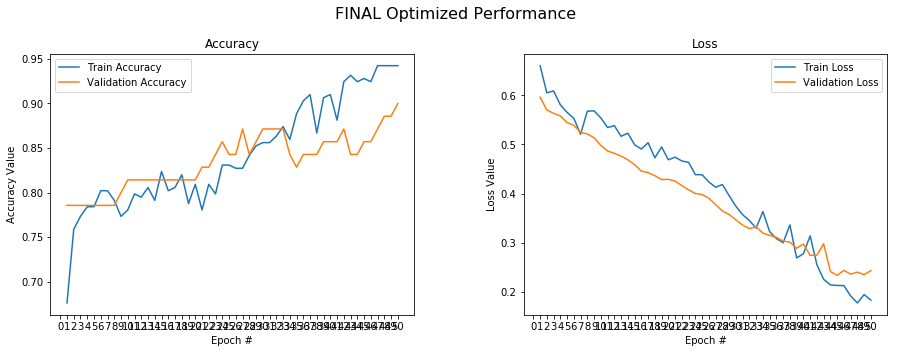


FINAL STABLE VALIDATION RESULTS
**FINAL VALIDATION LOSS: 0.2324**
**FINAL VALIDATION ACCURACY: 0.9000**

--- Final Confusion Matrix Results ---
True Positive (Real predicted Real) =  14
False Positive (Fake predicted Real) =  6
False Negative (Real predicted Fake) =  1
True Negative (Fake predicted Fake) =  49


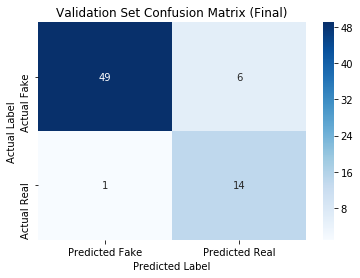

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math

# --- Configuration ---
IMG_SIZE = 128
SEQUENCE_LENGTH = 15 
NUM_CLASSES = 2
EPOCHS = 50 
BATCH_SIZE = 4 
DATA_DIR = 'dataset' 

# --- Data Preparation Function (Reads images from Part 1 output) ---
def create_sequence_data(data_dir, seq_length, img_size):
    X, Y, video_names = [], [], []
    
    for label in ['real', 'fake']:
        label_path = os.path.join(data_dir, label)
        
        video_frame_groups = {}
        try:
            for filename in os.listdir(label_path):
                if filename.endswith('.png'):
                    video_name = filename.split('_')[0] 
                    if video_name not in video_frame_groups:
                        video_frame_groups[video_name] = []
                    video_frame_groups[video_name].append(os.path.join(label_path, filename))
        except FileNotFoundError:
            print(f"ERROR: Directory {label_path} not found. Please run Part 1 (Preprocessing) first.")
            return np.array([]), np.array([])


        for vid_name, frame_paths in video_frame_groups.items():
            frame_paths.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

            if len(frame_paths) < seq_length:
                continue
                
            sequence = frame_paths[:seq_length]
            frames_data = []
            
            for frame_path in sequence:
                img = load_img(frame_path, target_size=(img_size, img_size))
                img_array = img_to_array(img)
                frames_data.append(img_array)
            
            frames_data = np.array(frames_data)
            
            X.append(frames_data)
            Y.append(1 if label == 'real' else 0)
    
    if not X:
        print("No sequences loaded. Check your data extraction in Part 1.")
        return np.array([]), np.array([])
        
    print(f"Loaded {len(X)} sequences (videos) with {seq_length} frames each.")
    
    X = np.array(X)
    Y = to_categorical(np.array(Y), NUM_CLASSES)
    
    return X, Y

# --- Load Data ---
X, Y = create_sequence_data(DATA_DIR, SEQUENCE_LENGTH, IMG_SIZE)

if X.size == 0:
    exit()

# Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- Define CNN-LSTM Model (Final Optimized) ---
print("Building FINAL Optimized model...")

# 1. ResNet50 Feature Extractor
resnet_base = ResNet50(weights='imagenet', include_top=False, 
                       input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
resnet_base.trainable = True 

# 2. Hybrid Model Construction
model = Sequential()
model.add(TimeDistributed(resnet_base, input_shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3)))
model.add(Dropout(0.6)) 
model.add(LSTM(512, return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# --- Define Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# --- Define ImageDataGenerators (The Stability Fix) ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# --- Generator Function for Sequences (The Stability Fix) ---
def sequence_generator(X_data, Y_data, batch_size, seq_length, datagen, shuffle=True):
    num_sequences = len(X_data)
    indices = np.arange(num_sequences) 
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
            
        for start_idx in range(0, num_sequences, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            X_batch = X_data[batch_indices]
            Y_batch = Y_data[batch_indices]

            X_aug = np.zeros_like(X_batch, dtype=np.float32)
            for i in range(X_batch.shape[0]):
                for j in range(seq_length):
                    X_aug[i, j] = datagen.random_transform(X_batch[i, j])
            
            yield X_aug, Y_batch

# Instantiate the generators
train_generator = sequence_generator(X_train, Y_train, BATCH_SIZE, SEQUENCE_LENGTH, train_datagen, shuffle=True)
val_generator = sequence_generator(X_val, Y_val, BATCH_SIZE, SEQUENCE_LENGTH, val_datagen, shuffle=False)


# --- Compile and Train ---
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

print("Starting FINAL optimized training...")

# Calculate steps per epoch
steps_per_epoch = math.ceil(len(X_train) / BATCH_SIZE)
validation_steps = math.ceil(len(X_val) / BATCH_SIZE)

# *** ADJUSTED CLASS WEIGHTS: MAXIMIZING TRUE POSITIVES (REAL) ***
class_weights = {0: 1.05,  # FAKE: Reduced to reduce bias against REAL videos
                 1: 1.15}  # REAL: Increased to encourage confident REAL identification

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_schedule],
    class_weight=class_weights,
    verbose=1
)

# --- Final Evaluation and Reporting ---
loss, accuracy = model.evaluate(X_val, Y_val, verbose=0)

# Save the final model and data arrays for the next cell
model.save('deepfake_resnet_final_model.h5')
np.save('X_val.npy', X_val)
np.save('Y_val.npy', Y_val)
print("Final Model and validation data saved.")

# 1. Accuracy and Loss Plot
def plot_analysis(history, epochs):
    """
    Visualizes the training and validation accuracy and loss over epochs.
    Also includes a check to print if Early Stopping was triggered.
    """
    
    epochs_run = len(history.history['loss'])
    
    # *** EARLY STOPPING INDICATOR ***
    if epochs_run < epochs:
        print(f"\n*** EARLY STOPPING TRIGGERED! ***")
        print(f"Training successfully stopped at Epoch {epochs_run} (out of {epochs}).")
    else:
        print(f"\nTraining ran for the full {epochs} epochs.")
    # ********************************

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    t = f.suptitle('FINAL Optimized Performance', fontsize=16)
    f.subplots_adjust(top=0.85, wspace=0.3)
    
    epoch_list = list(range(1, epochs_run + 1))
    
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs_run + 1, 1))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch #')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")
    
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs_run + 1, 1))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch #')
    ax2.set_title('Loss')
    ax2.legend(loc="best")
    plt.savefig('cnn_lstm_performance_final.png')
    plt.show()

# 2. Confusion Matrix and Final Metrics Plot
def print_confusion_matrix_and_plot(model, X_val, Y_val, final_loss, final_accuracy):
    """Calculates, prints, and visualizes the confusion matrix."""
    
    Y_pred = model.predict(X_val)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_true_classes = np.argmax(Y_val, axis=1)

    cm = confusion_matrix(Y_true_classes, Y_pred_classes)
    
    # Print Final Results
    print("\n" + "="*50)
    print("FINAL STABLE VALIDATION RESULTS")
    print(f"**FINAL VALIDATION LOSS: {final_loss:.4f}**")
    print(f"**FINAL VALIDATION ACCURACY: {final_accuracy:.4f}**")
    print("="*50)

    # Print Confusion Matrix Metrics
    print('\n--- Final Confusion Matrix Results ---')
    print('True Positive (Real predicted Real) = ', cm[1][1])
    print('False Positive (Fake predicted Real) = ', cm[0][1])
    print('False Negative (Real predicted Fake) = ', cm[1][0])
    print('True Negative (Fake predicted Fake) = ', cm[0][0])
    
    # Plotting the Confusion Matrix
    df_cm = pd.DataFrame(cm, index=['Actual Fake', 'Actual Real'], columns=['Predicted Fake', 'Predicted Real'])
    plt.figure(figsize=(6, 4))
    sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues') 
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Validation Set Confusion Matrix (Final)')
    plt.savefig('cnn_lstm_confusion_matrix_final.png')
    plt.show()


# --- Execution of Visualizations ---

# 1. Run the epoch plot
plot_analysis(history, EPOCHS)

# 2. Run the confusion matrix calculation and plot
print_confusion_matrix_and_plot(model, X_val, Y_val, loss, accuracy)